In [1]:
import os
import datetime
import requests

import brownie

from utils.network_utils import connect_eth_alchemy
from utils.contract_utils import init_contract

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")

In [3]:
connect_eth_alchemy()

In [4]:
vlcvx_addr = "0xD18140b4B819b895A3dba5442F959fA44994AF50"

In [5]:
current_block = brownie.web3.eth.block_number

In [6]:
query = f"https://api.etherscan.io/api?module=account&action=txlist&address={vlcvx_addr}&startblock=0&endblock=9999999999&sort=asc&page=1&offset=10000&apikey={os.environ['ETHERSCAN_API_KEY']}"
response = requests.post(query)

In [7]:
interacting_addrs = []
for tx in dict(response.json())['result']:
    interacting_addrs.append(tx['from'])
len(interacting_addrs)

4227

In [8]:
vlcvx = init_contract(vlcvx_addr)

In [9]:
vlcvx_balances = []
with brownie.multicall():
    for addr in interacting_addrs:
        vlcvx_balances.append(vlcvx.lockedBalanceOf(addr))

In [10]:
df_vlcvx_balances = pd.DataFrame({"addr": interacting_addrs, "vlcvx_balance": vlcvx_balances})
df_vlcvx_balances

,addr,vlcvx_balance
0,0x947b7742c403f20e5faccdac5e092c943e7d0277,0
1,0x947b7742c403f20e5faccdac5e092c943e7d0277,0
2,0x947b7742c403f20e5faccdac5e092c943e7d0277,0
3,0x947b7742c403f20e5faccdac5e092c943e7d0277,0
4,0x947b7742c403f20e5faccdac5e092c943e7d0277,0
...,...,...
4222,0xe7e58a7dbfdcd14d77018bcd5fbbecb4f5153b53,3434376594074574140307
4223,0xe90b4aa6002e263031e9a05d50ce8709b9f92fa8,1427936555955761917982
4224,0x6384d3861d0dadcdc758d06da7d9628e4ed41d1a,2457966123792808414221
4225,0x8aa1de245737f9323877684be0dc7651aff4531f,501342760862516274354


In [11]:
df_vlcvx_balances = df_vlcvx_balances.where(df_vlcvx_balances.vlcvx_balance > 0)
df_vlcvx_balances['vlcvx_balance'] *= 1e-18
df_vlcvx_balances.drop_duplicates(inplace=True)
df_vlcvx_balances

,addr,vlcvx_balance
0,NaN,NaN
5,0xaac0aa431c237c2c0b5f041c8e59b3f1a43ac78f,1717677.369072
6,0x94dfce828c3daaf6492f1b6f66f9a1825254d24b,547261.932749
7,0xc7c022bd85529bed1b92de4ba847f3f4e8fd5cbf,499973.912018
8,0x2ba8c59c99c94ac5d3b2af7019d2861c640e91f7,6568.236533
...,...,...
4214,0x375f95fb45811ace248adc5baee5228d91ffca50,5139.642443
4215,0x8da4b8ae83ea2fcc7bdbaf9b6042b819cd2dae3c,128.734523
4216,0x40997f435728ecc6d2af4e50bacd091386017433,1337.69
4217,0xf960a6adc4ea8e2d3c873dc3116cfdb8a5d9c883,4016.956378


In [12]:
export_df = df_vlcvx_balances.dropna().sort_values(by=['vlcvx_balance'], ascending=False).reset_index().drop(columns=['index'])
export_df

,addr,vlcvx_balance
0,0xaac0aa431c237c2c0b5f041c8e59b3f1a43ac78f,1717677.369072
1,0x9c5083dd4838e120dbeac44c052179692aa5dac5,1000000.002648
2,0xa22eb3338dfd69458513a1f6d4742ab29f7ef333,1000000.0
3,0xb3df5271b92e9fd2fed137253bb4611285923f16,775043.652014
4,0x94dfce828c3daaf6492f1b6f66f9a1825254d24b,547261.932749
...,...,...
2120,0x94234cfd63e20f280111daf8627c95c0ab2c3ac7,2.218662
2121,0xe16f4f24fbc389441a83222b6fe7c61a1b0d50ff,1.470637
2122,0x25b28ee7f335f0396f41f129039f1583345b21b8,1.222147
2123,0xff77fdef2685402f9064cd14ae24aa4609d8d867,1.0


In [20]:
now = datetime.datetime.utcnow()
now = datetime.datetime.strftime(now, "%Y-%m-%d--%H-%M")
export_df.to_csv(f'lockooooors_{now}.csv')

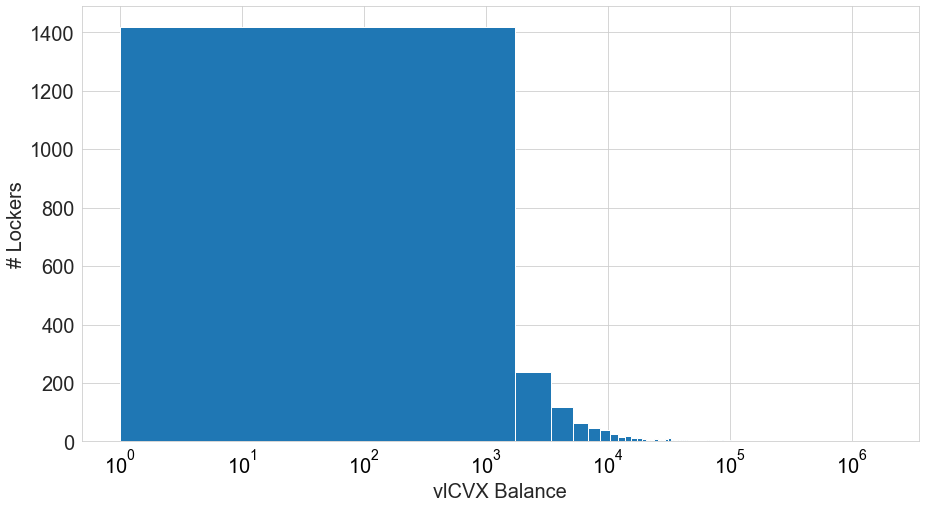

In [14]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))

ax.hist(export_df.vlcvx_balance, bins=1000)

ax.set_ylabel("# Lockers", fontsize=20)
ax.set_xlabel("vlCVX Balance", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)

ax.set_xscale("log")
